[[Model]]
    (Model(polynomial, prefix='p1_') + (((((Model(gaussian, prefix='g0_') + Model(gaussian, prefix='g1_')) + Model(gaussian, prefix='g2_')) + Model(gaussian, prefix='g3_')) + Model(gaussian, prefix='g4_')) + Model(gaussian, prefix='g5_')))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 575
    # data points      = 6987
    # variables        = 19
    chi-square         = 9340.61825
    reduced chi-square = 1.34050205
    Akaike info crit   = 2066.47398
    Bayesian info crit = 2196.65830
    R-squared          = 0.98209009
[[Variables]]
    p1_c0:         1.61524884 +/- 0.02809286 (1.74%) (init = 0.3571429)
    g0_amplitude:  40455.4861 +/- 273.956082 (0.68%) (init = 5000)
    g0_center:     329.457233 +/- 0.24032165 (0.07%) (init = 329)
    g0_sigma:      35.3806738 +/- 0.21793031 (0.62%) (init = 85.73819)
    g0_fwhm:       83.3151183 +/- 0.51318666 (0.62%) == '2.3548200*g0_sigma'
    g0_height:     456.164423 +/- 3.52078644 (0.77%) == '0.39894

0

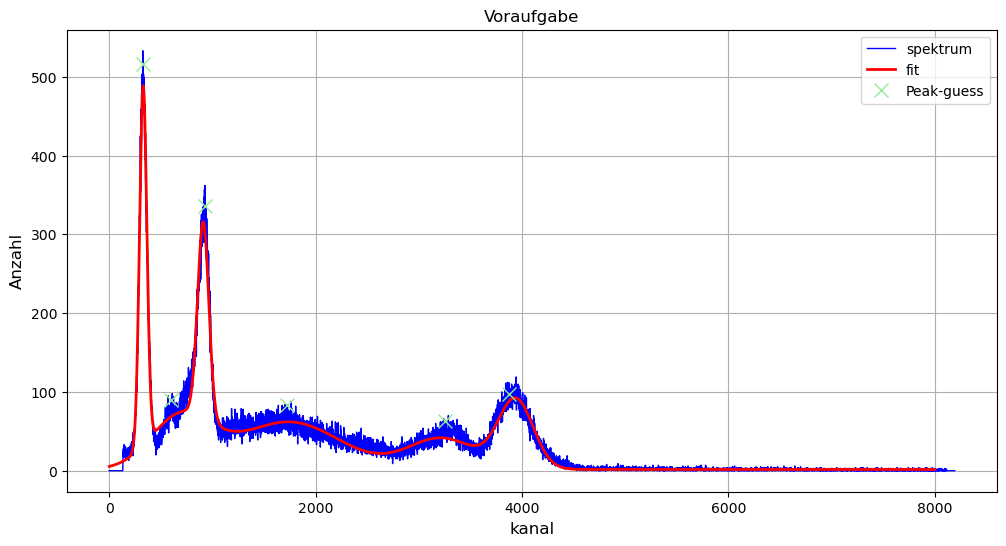

In [43]:
import matplotlib.pyplot as plt # to make plots
import numpy as np # for array manipulation and math functions
import scipy.signal as scs # for signal analysis
import glob # for finding files
import os as os
import warnings
import array as arr
import uncertainties
from scipy import optimize
from scipy.optimize import curve_fit
from uncertainties import ufloat as uf
from uncertainties.umath import *
from uncertainties import unumpy as un
from uncertainties.unumpy import nominal_values as n
from uncertainties.unumpy import std_devs as s
# import fit models from the lmfit package
from lmfit.models import ExponentialModel, GaussianModel, PolynomialModel
from lmfit import Model


####################################################################################################################
#Warnings disabled
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')
#####################################################################################################################

#Die beiden Funktionen sind leichte Abänderungen von Teilen eines Skriptes zur Auswertung von Radioteleskop-Spektren, das uns im Rahmen 
#eines Praktikum 4 Versuches gegeben wurde
# def getSignal(x,y,width_guess,NPeaks,smoothing,signal_range,signal_thr = None):
#     s_mask = (x>signal_range[0])&(x<signal_range[1])
#     x_s = x[s_mask]
#     signal_use = (y)[s_mask]

#     if (smoothing == 1):
#         b,a = scs.butter(3,0.07)
#         zi = scs.lfilter_zi(b, a)
#         z, _ = scs.lfilter(b, a, x_s, zi=zi*signal_use[0])
#         z2, _ = scs.lfilter(b, a, z, zi=zi*z[0])
#         signal_smooth = scs.filtfilt(b, a, signal_use)
    
#     else:
#        signal_smooth = signal_use

#     amp = (np.max(signal_smooth)-np.min(signal_smooth))
#     minimum = np.min(signal_smooth)
    
#     s_min = signal_range[0]+50
#     s_max = signal_range[1]-50
    
#     s_mask_narrow = ((x_s>s_min)&(x_s<s_max))
    
#     if signal_thr is None:
#         peaks = scs.find_peaks(signal_smooth[s_mask_narrow], width=width_guess)
#         prom = peaks[1]['prominences']
#     else:
#         peaks = scs.find_peaks(signal_smooth[s_mask_narrow], height = minimum + signal_thr*amp, width=width_guess)
#         prom = peaks[1]['peak_heights']
#     prom_save = prom.copy()
#     prom.sort()
    
#     # only use the most prominent peaks for our first guess of the Gauss peak centers:
#     if NPeaks > len(prom): # if not enough peaks are found, reduce NPeaks!
#         NPeaks = len(prom)
#         print("reduced NPeaks to "+str(NPeaks))
#     peaks_use = peaks[0][prom_save>=prom[-NPeaks]] 
#     peak_width = peaks[1]['widths'][prom_save>=prom[-NPeaks]]
#     # save the peak positions for later
#     gauss_centers = x_s[s_mask_narrow][peaks_use]
#     peak_y = signal_use[s_mask_narrow][peaks_use]
#     return x_s, signal_use, gauss_centers, peak_y, peak_width, signal_smooth

# def detailedSignalFit(x_s, signal_use,add_gaussians, gauss_centers, peak_width, center_variation,sigma_min,sigma_max,amp_min,amp_value_guess,poly_deg = 3):
#     mask_edges = np.logical_or(x_s<signal_range[0]+50, x_s>signal_range[1]-50)
#     if not (poly_deg is None):
#         poly1 = PolynomialModel(degree=poly_deg, prefix='p1_')
#         p_s = poly1.guess(signal_use[mask_edges],x=x_s[mask_edges])

#     # set up the first Gauss peak
#     gaussX = GaussianModel(prefix='g'+str(0)+'_')
#     gaussians = gaussX
#     p_gauss = gaussX.make_params()
#     if (poly_deg is None): p_s = p_gauss 
#     p_gauss['g'+str(0)+'_center'].set(value=gauss_centers[0], min=gauss_centers[0]-center_variation, max=gauss_centers[0]+center_variation) # center
#     p_gauss['g'+str(0)+'_sigma'].set(value=peak_width[0], min=sigma_min, max=sigma_max) # width of peak
#     p_gauss['g'+str(0)+'_amplitude'].set(value=amp_value_guess, min=amp_min) # amplitude of peak

#     # now set up the rest of the Gauss peaks:
#     for i in np.arange(1,len(gauss_centers)):
#         gaussX = GaussianModel(prefix='g'+str(i)+'_')
#         gaussians = gaussians + gaussX
#         p_gauss.update(gaussX.make_params())
#         p_gauss['g'+str(i)+'_center'].set(value=gauss_centers[i], min=gauss_centers[i]-center_variation, max=gauss_centers[i]+center_variation)
#         p_gauss['g'+str(i)+'_sigma'].set(value=peak_width[i], min=sigma_min, max=sigma_max)
#         p_gauss['g'+str(i)+'_amplitude'].set(value=amp_value_guess, min=amp_min)
    
#     # add some extra gauss peaks with free parameters to patch up anything left
#     for i in np.arange(len(gauss_centers),len(gauss_centers)+add_gaussians):
#         gaussX = GaussianModel(prefix='g'+str(i)+'_')
#         gaussians = gaussians + gaussX
#         p_gauss.update(gaussX.make_params()) 
#         p_gauss['g'+str(i)+'_center'].set(min=np.min(x_s)+50, max=np.max(x_s)-50)
#         p_gauss['g'+str(i)+'_sigma'].set(min=sigma_min, max=sigma_max)
#         p_gauss['g'+str(i)+'_amplitude'].set(min=amp_min)
    
#     # assemble the model:  polynomial background + Gauss peaks
#     if not (poly_deg is None): mod_s = poly1 + gaussians
#     else: mod_s = gaussians
#     # include parameters for the Gauss peaks in the parameter list
#     p_s.update(p_gauss)
#     # initialize model with the parameters
#     init_s = mod_s.eval(p_s, x=x_s)
#     # fit model
#     out_s = mod_s.fit(signal_use, p_s, x=x_s)
#     return p_s, out_s, mod_s, gaussians

# def Fit_allinone(x,y,width,N,center_var,s_range,amp_guess,polydeg=None,ampmin=0,sigmamin=0,sigmamax=500,more_gaus=0,smoothe= 1):
#     x_s, signal_use, gauss_centers, peak_y, peak_width, signal_smooth = getSignal(x,y,width,N, smoothe,s_range,signal_thr= None)
#     p_s, out_s, mod_s, mod_s_only = detailedSignalFit(x_s, signal_use,more_gaus, gauss_centers, peak_width,center_var,sigma_min=sigmamin,sigma_max=sigmamax,amp_min=ampmin,amp_value_guess=amp_guess,poly_deg= polydeg)
#     lolo1=[]
#     lala1=[]
#     names=[]
#     i=0
#     if not (polydeg is None):
#         n=polydeg
#     else:
#         n=-1
#     for name,param in out_s.params.items():
#         if i>n:
#             if out_s.errorbars==True:
#                 lala1.append(param.stderr)
#             else:
#                 lala1.append(0)
#             names.append(name)
#             lolo1.append(param.value)
#         i=i+1
#     result=out_s.best_fit
#     return p_s,x_s,result,lolo1,lala1,out_s,mod_s,mod_s_only,names,gauss_centers,peak_y

def getSignal(x,y,width_guess,NPeaks,smoothing,signal_range,minmaxvar=50,signal_thr = None):
    s_mask = (x>signal_range[0])&(x<signal_range[1])
    x_s = x[s_mask]
    signal_use = (y)[s_mask]

    if (smoothing == 1):
        b,a = scs.butter(3,0.07)
        zi = scs.lfilter_zi(b, a)
        z, _ = scs.lfilter(b, a, x_s, zi=zi*signal_use[0])
        z2, _ = scs.lfilter(b, a, z, zi=zi*z[0])
        signal_smooth = scs.filtfilt(b, a, signal_use)
    
    else:
       signal_smooth = signal_use

    amp = (np.max(signal_smooth)-np.min(signal_smooth))
    minimum = np.min(signal_smooth)
    
    s_min = signal_range[0]+minmaxvar
    s_max = signal_range[1]-minmaxvar  #10
    
    s_mask_narrow = ((x_s>s_min)&(x_s<s_max))
    
    if signal_thr is None:
        peaks = scs.find_peaks(signal_smooth[s_mask_narrow], width=width_guess)
        prom = peaks[1]['prominences']
    else:
        peaks = scs.find_peaks(signal_smooth[s_mask_narrow], height = minimum + signal_thr*amp, width=width_guess)
        prom = peaks[1]['peak_heights']
    prom_save = prom.copy()
    prom.sort()
    
    # only use the most prominent peaks for our first guess of the Gauss peak centers:
    if NPeaks > len(prom): # if not enough peaks are found, reduce NPeaks!
        NPeaks = len(prom)
        print("reduced NPeaks to "+str(NPeaks))
    peaks_use = peaks[0][prom_save>=prom[-NPeaks]] 
    peak_width = peaks[1]['widths'][prom_save>=prom[-NPeaks]]
    # save the peak positions for later
    gauss_centers = x_s[s_mask_narrow][peaks_use]
    peak_y = signal_use[s_mask_narrow][peaks_use]
    return x_s, signal_use, gauss_centers, peak_y, peak_width, signal_smooth

def detailedSignalFit(x_s, signal_use,add_gaussians, gauss_centers, peak_width, center_variation,sigma_min,sigma_max,amp_min,amp_value_guess,y_err=[],poly_deg = 3,edges=50,s_range=[]):
    mask_edges = np.logical_or(x_s<s_range[0]+edges, x_s>s_range[1]-edges)  #20
    if not (poly_deg is None):
        poly1 = PolynomialModel(degree=poly_deg, prefix='p1_')
        p_s = poly1.guess(signal_use[mask_edges],x=x_s[mask_edges])

    # set up the first Gauss peak
    gaussX = GaussianModel(prefix='g'+str(0)+'_')
    gaussians = gaussX
    p_gauss = gaussX.make_params()
    if (poly_deg is None): p_s = p_gauss 
    p_gauss['g'+str(0)+'_center'].set(value=gauss_centers[0], min=gauss_centers[0]-center_variation, max=gauss_centers[0]+center_variation) # center
    p_gauss['g'+str(0)+'_sigma'].set(value=peak_width[0], min=sigma_min, max=sigma_max) # width of peak
    p_gauss['g'+str(0)+'_amplitude'].set(value=amp_value_guess, min=amp_min) # amplitude of peak

    # now set up the rest of the Gauss peaks:
    for i in np.arange(1,len(gauss_centers)):
        gaussX = GaussianModel(prefix='g'+str(i)+'_')
        gaussians = gaussians + gaussX
        p_gauss.update(gaussX.make_params())
        p_gauss['g'+str(i)+'_center'].set(value=gauss_centers[i], min=gauss_centers[i]-center_variation, max=gauss_centers[i]+center_variation)
        p_gauss['g'+str(i)+'_sigma'].set(value=peak_width[i], min=sigma_min, max=sigma_max)
        p_gauss['g'+str(i)+'_amplitude'].set(value=amp_value_guess, min=amp_min)
    
    # add some extra gauss peaks with free parameters to patch up anything left
    for i in np.arange(len(gauss_centers),len(gauss_centers)+add_gaussians):
        gaussX = GaussianModel(prefix='g'+str(i)+'_')
        gaussians = gaussians + gaussX
        p_gauss.update(gaussX.make_params()) 
        p_gauss['g'+str(i)+'_center'].set(min=np.min(x_s)+50, max=np.max(x_s)-50)
        p_gauss['g'+str(i)+'_sigma'].set(min=sigma_min, max=sigma_max)
        p_gauss['g'+str(i)+'_amplitude'].set(min=amp_min)
    
    # assemble the model:  polynomial background + Gauss peaks
    if not (poly_deg is None): mod_s = poly1 + gaussians
    else: mod_s = gaussians
    # include parameters for the Gauss peaks in the parameter list
    p_s.update(p_gauss)
    # initialize model with the parameters
    init_s = mod_s.eval(p_s, x=x_s)
    # fit model
    if (len(y_err)>0):
        out_s = mod_s.fit(signal_use, p_s, x=x_s,weights=1.0/y_err,nan_policy='omit')
    else:
        out_s = mod_s.fit(signal_use, p_s, x=x_s)
    return p_s, out_s, mod_s, gaussians

def Fit_allinone(x,y,N,y_err=[],width=10,center_var=20,s_range=[],amp_guess=50,polydeg=None,ampmin=0,sigmamin=0,sigmamax=500,more_gaus=0,smoothe= 1,return_in_lists=None,one_list=None,signal_t=None,minmaxvar=50,edges=50):
    if not s_range:
        s_range=[x[0],x[len(x)-1]]
    s_mask = (x>s_range[0])&(x<s_range[1])
    if (len(y_err)>0):
        y_errs = y_err[s_mask]
    else:
        y_errs=[]
    x_s, signal_use, gauss_centers, peak_y, peak_width, signal_smooth = getSignal(x,y,width,N, smoothe,s_range,signal_thr= signal_t,minmaxvar=minmaxvar)
    p_s, out_s, mod_s, mod_s_only = detailedSignalFit(x_s, signal_use,more_gaus, gauss_centers, peak_width,center_var,sigma_min=sigmamin,sigma_max=sigmamax,amp_min=ampmin,amp_value_guess=amp_guess,y_err=y_errs,poly_deg= polydeg,s_range=s_range,edges=edges)
    lolo1=[]
    lala1=[]
    names=[]
    i=0
    if not (polydeg is None):
        n=polydeg
    else:
        n=-1
    for name,param in out_s.params.items():
        if i>n:
            if out_s.errorbars==True:
                lala1.append(param.stderr)
            else:
                lala1.append(0)
            names.append(name)
            lolo1.append(param.value)
        i=i+1
    i=0
    count=0
    params_list=[list() for x in range(int(len(lolo1)/5))]
    stderr_list=[list() for x in range(int(len(lolo1)/5))]
    centers=[]
    Amplitudes=[]
    centerser=[]
    Amplitudeser=[]
    for h in range(len(lolo1)):
        params_list[i].append(lolo1[h])
        stderr_list[i].append(lala1[h])
        count=count+1
        if (count==5):
            i=i+1
            count=0
    result=out_s.best_fit
    if (return_in_lists is None):
        return p_s,x_s,result,lolo1,lala1,out_s,mod_s,mod_s_only,names,gauss_centers,peak_y
    elif (one_list is None):
        return_other=[gauss_centers,peak_y,names,p_s,mod_s,mod_s_only]
        return_fit=[x_s,result]
        return_fit_results=[params_list,stderr_list,lolo1,lala1,out_s]
        return return_fit,return_fit_results,return_other
    elif not (one_list is None):
        return_list=[x_s,result,lolo1,lala1,out_s,gauss_centers,peak_y,p_s,mod_s,mod_s_only,names]
        return return_list


def Plotter(x,y,N_plots,labels,colors,linewidths,styles,markersizes,xtitle,ytitle,title,name):
    figure=plt.figure(figsize=(12,6))
    plt.title(title)
    for i in range(0,N_plots):
        plt.plot(x[i],y[i],styles[i],color=colors[i],linewidth=linewidths[i],label=labels[i],markersize=markersizes[i])
    plt.xlabel(xtitle,fontsize=12)
    plt.ylabel(ytitle,fontsize=12)
    plt.grid()
    plt.legend()
    plt.savefig(name+'.png')
    plt.show
    return 0

def Tab(names,data,dataer,filename,separat_runden=[]):
    runden=separat_runden
    with open(filename+'.txt', 'w') as f:
        f.write('{l')
        for h in range(0,len(names)-1):
            f.write('|l')
        f.write('}\n')
        for h in range(0,len(names)):
            if not (h==len(names)-1):
                f.write(names[h]+ '&')
            else:
                f.write(names[h]+ '\\\\')
            runden.append(3)
        f.write('\n')
        f.write('\hline')
        f.write('\n')
        count=0
        for i in range(0,len(data)):
            if not(dataer[i]==0):
                if (np.sign(np.log10(dataer[i]))*int(np.abs(np.log10(dataer[i]))) <=0):
                    f.write('$'+str(np.round(data[i],runden[count]+int(np.abs(np.log10(dataer[i])))))+ '\pm'+str(np.round(dataer[i],runden[count]+int(np.abs(np.log10(dataer[i])))))+'$')
                else:
                    f.write('$'+str(np.round(data[i],runden[count]-int(np.abs(np.log10(dataer[i])))))+ '\pm'+str(np.round(dataer[i],runden[count]-int(np.abs(np.log10(dataer[i])))))+'$')
            else:
                f.write('$'+str(np.round(data[i],runden[count]+int(np.abs(np.log10(data[i])))))+'$')
            if not (count==(len(names)-1)):
                f.write('&')
            else:
                f.write('\\\\')
                f.write('\n')
                count=-1
            count=count+1
        f.close
    return 0

def filetoxy(name):
    data=np.loadtxt(name)
    x=data[:,0]
    y=data[:,1]
    y_err=np.zeros(shape=(len(y)))
    y_err=np.sqrt(y)
    y2=un.uarray(y,y_err)
    return x,y,y2
signal_range=[0,8000]
path1='../data/Voraufgabe/'
data1=np.loadtxt(path1+'spectrum.txt')
x,y,yer=filetoxy(path1+'spectrum.txt')
#x=data1[:,0]
#y=data1[:,1]
Yer=s(yer)
p_s,x_s,Rfit,params,params_stderr,result,model,model_gaus,names,gc,py=Fit_allinone(x,y,y_err=Yer,width=20,N=6,center_var=100,s_range=signal_range,amp_guess=5000,polydeg=0,more_gaus=0)
print(result.fit_report(min_correl=0.5))

data_x=[x,x_s,gc]
data_y=[y,Rfit,py]
Plotter(data_x,data_y,3,['spektrum','fit','Peak-guess'],['blue','red','lightgreen'],[1,2,10],['-','-','x'],[0,0,10],'kanal','Anzahl','Voraufgabe','voraufgabe6_8000')
print(params)
print(names)
Namen=['Amplitude','center','sigma','fwhm','heigth']
namen_gaus=['Integral [#]','\mu [Kanal]]','\sigma [Kanal]','fwhm [Kanal]','Hoehe [#]']
Tab(namen_gaus,params,params_stderr,'Tabvoraufgabe')
# with open('Tab1'+'.txt', 'w') as f:
#     for h in range(0,len(Namen)):
#         f.write(Namen[h]+ '\t')
#     f.write('\n')
#     count=0
#     for i in range(0,len(params)):
#         f.write(str(np.round(params[i],3))+ '\t')
#         if (count==(len(Namen)-1)):
#             f.write('\n')
#             count=-1
#         count=count+1
#     f.close

['../data/Voraufgabe\\EuBackground.txt', '../data/Voraufgabe\\EuMessung.txt']


0

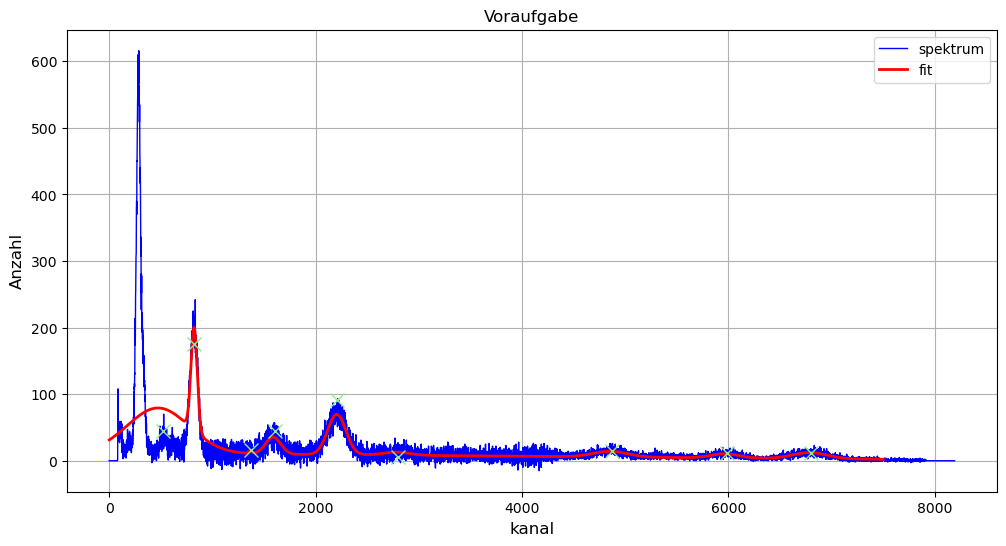

In [7]:
names=glob.glob(path1+'Eu*.txt')
print(names)
data=np.loadtxt(names[1])
databg=np.loadtxt(names[0])
x=data[:,0]
y=data[:,1]
xbg=databg[:,0]
ybg=databg[:,1]
y=y-ybg
# x=xd-xbg
# y=yd-ybg
p_s,x_s,Rfit,params,params_stderr,result,model,model_gaus,names,gc,py=Fit_allinone(x,y,width=50,N=9,center_var=50,s_range=[0,7500],amp_guess=5000,polydeg=1,more_gaus=0)
data_x=[x,x_s,gc]
data_y=[y,Rfit,py]
Plotter(data_x,data_y,3,['spektrum','fit',''],['blue','red','lightgreen'],[1,2,10],['-','-','x'],[0,0,10],'kanal','Anzahl','Voraufgabe','voraufgabe')


['../data\\Erde-Ge.txt']


C:\Users\Banton\AppData\Local\Temp\ipykernel_13124\2920457287.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


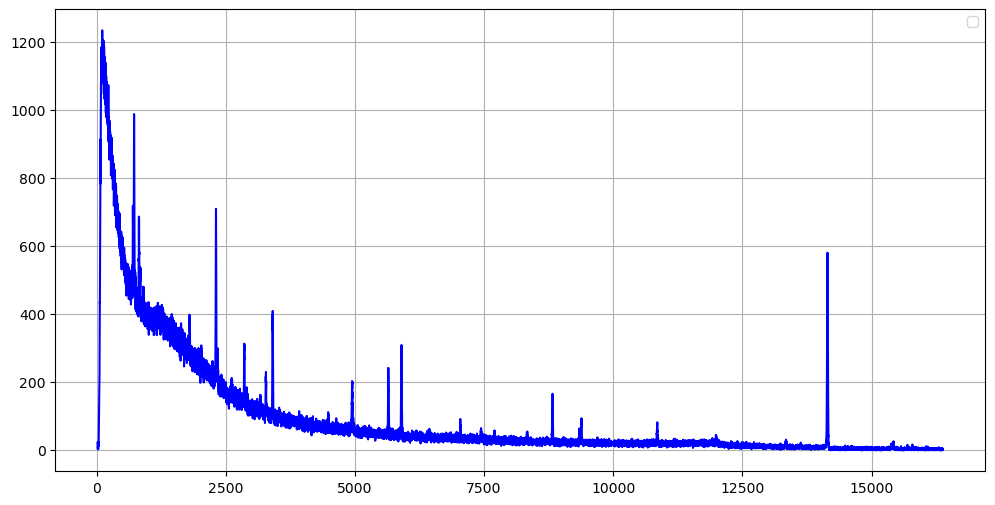

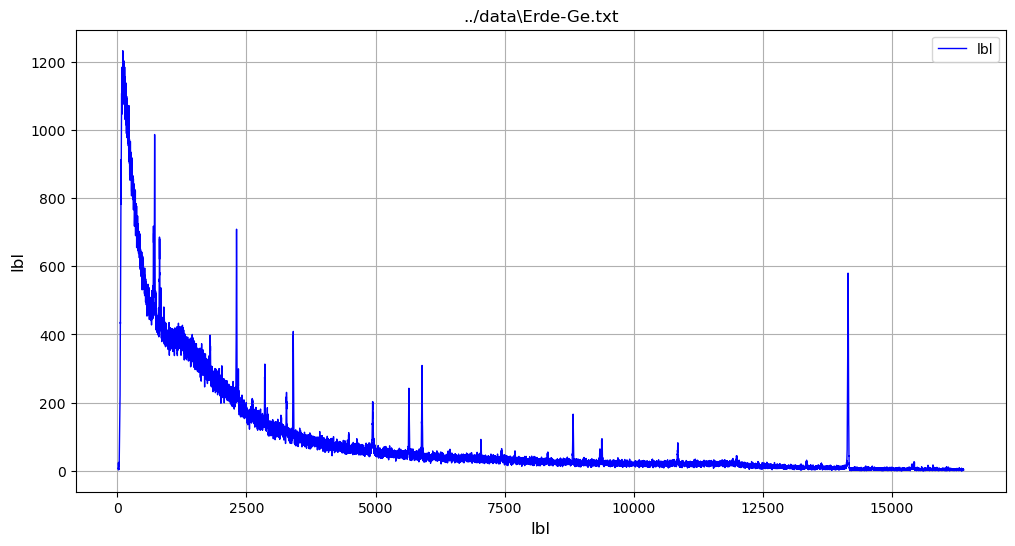

In [3]:
# amp = (np.max(signal_smooth)-np.min(signal_smooth))
# minimum = np.min(signal_smooth)
#threshold = minimum + signal_thr*amp

# plt.plot(x_s,signal_use,label='signal')
# plt.plot(x_s,signal_smooth,label='smoothed signal')
# plt.plot([np.min(x_s),np.max(x_s)],[threshold,threshold],label='signal_thr')
# plt.scatter(gauss_centers,peak_y,color="red",zorder=10)
# plt.legend()

# print(gauss_centers)
# print(peak_y)
# print(peak_width)
names=glob.glob('../data/'+'Erde*.txt')
print(names)
data=np.loadtxt(names[0])
x=data[:,0]
y=data[:,1]
figure=plt.figure(figsize=(12,6))
# plt.title(title)
plt.plot(x,y,'b-')
# plt.xlabel(xtitle,fontsize=12)
# plt.ylabel(ytitle,fontsize=12)
plt.grid()
plt.legend()
# plt.savefig(name+'.png')
plt.show

for name in names:
    data=np.loadtxt(name)
    x=data[:,0]
    y=data[:,1]
    Plotter([x],[y],1,['lbl'],['blue'],[1],['-'],[0],'lbl','lbl',name,'lbl')